In [ ]:
import os
import sys
import glob
import argparse
import requests
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from tqdm import tqdm

from keras import __version__
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

IM_WIDTH, IM_HEIGHT = 299, 299 #fixed size for InceptionV3
NB_EPOCHS = 10
BAT_SIZE = 32
FC_SIZE = 1024
DROP_RT = 0.5
NB_IV3_LAYERS_TO_FREEZE = 172

In [79]:
def get_nb_files(directory):
  """Get number of files by searching directory recursively"""
  if not os.path.exists(directory):
    return 0
  cnt = 0
  for r, dirs, files in os.walk(directory):
    for dr in dirs:
      cnt += len(glob.glob(os.path.join(r, dr + "/*")))
  return cnt


def setup_to_transfer_learn(model, base_model):
  """Freeze all layers and compile the model"""
  for layer in base_model.layers:
    layer.trainable = False
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


def add_new_last_layer(base_model, nb_classes):
  """Add last layer to the convnet

  Args:
    base_model: keras model excluding top
    nb_classes: # of classes

  Returns:
    new keras model with last layer
  """
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(FC_SIZE, activation='relu')(x)
  x = Dropout(DROP_RT)(x)
  predictions = Dense(nb_classes, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)

  return model


def setup_to_finetune(model):
  """Freeze the bottom NB_IV3_LAYERS and retrain the remaining top layers.

  note: NB_IV3_LAYERS corresponds to the top 2 inception blocks in the inceptionv3 arch

  Args:
    model: keras model
  """
  for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
     layer.trainable = False
  for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
     layer.trainable = True
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


def train(train_dir, val_dir,
        nb_epoch=NB_EPOCHS, batch_size=BAT_SIZE,
        output_model_file='inceptionv3-ft.model',
        plot='store_true'):
  """Use transfer learning and fine-tuning to train a network on a new dataset"""
  nb_train_samples = get_nb_files(train_dir)
  nb_classes = len(glob.glob(train_dir + "/*"))
  nb_val_samples = get_nb_files(val_dir)
  nb_epoch = int(nb_epoch)
  batch_size = int(batch_size)

  # data prep
  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
  )
  test_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True
  )

  train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=batch_size,
  )

  validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=batch_size,
  )

  class_indices = train_generator.class_indices
  class_indices = pd.DataFrame.from_dict(dict(zip(class_indices.values(), class_indices.keys())), orient='index')
  class_indices.to_csv('class_indices.csv', sep=',', header=False)
  print(class_indices)

  # setup model
  base_model = InceptionV3(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
  model = add_new_last_layer(base_model, nb_classes)

  # transfer learning
  setup_to_transfer_learn(model, base_model)

  history_tl = model.fit_generator(
    train_generator,
    epochs=nb_epoch,
    steps_per_epoch=nb_train_samples/batch_size,
    validation_data=validation_generator,
    validation_steps=nb_val_samples/batch_size,
    class_weight='auto')

  # fine-tuning
  setup_to_finetune(model)

  history_ft = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples/batch_size,
    epochs=nb_epoch,
    validation_data=validation_generator,
    validation_steps=nb_val_samples/batch_size,
    class_weight='auto')

  model.save(output_model_file)

  if plot:
    plot_training(history_ft)
    

def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')

  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()

Found 2394 images belonging to 25 classes.
Found 798 images belonging to 25 classes.
              0
0         beans
1          cake
2         candy
3        cereal
4         chips
5     chocolate
6        coffee
7          corn
8          fish
9         flour
10        honey
11          jam
12        juice
13         milk
14         nuts
15          oil
16        pasta
17         rice
18         soda
19       spices
20        sugar
21          tea
22  tomatosauce
23      vinegar
24        water
Epoch 1/12
75/74 [==============================] - 107s - loss: 3.5123 - acc: 0.1111 - val_loss: 2.7414 - val_acc: 0.2068
Epoch 2/12
75/74 [==============================] - 88s - loss: 2.7005 - acc: 0.2102 - val_loss: 2.3819 - val_acc: 0.2932
Epoch 3/12
75/74 [==============================] - 89s - loss: 2.4702 - acc: 0.2723 - val_loss: 2.0625 - val_acc: 0.4160
Epoch 4/12
75/74 [==============================] - 89s - loss: 2.2623 - acc: 0.3228 - val_loss: 2.0174 - val_acc: 0.3722
Epoch 5/12

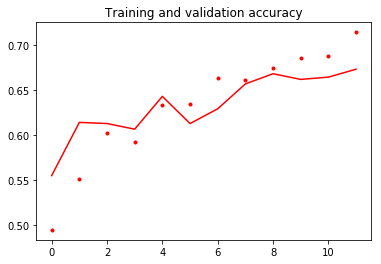

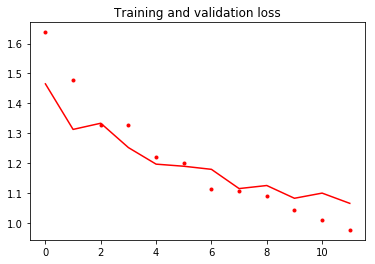

In [34]:
train(train_dir='/data/train', val_dir='/data/validation')

In [102]:
IM_WIDTH, IM_HEIGHT = 299, 299 #fixed size for InceptionV3

def predict(model, img):
  """Run model prediction on image
  Args:
    model: keras model
    img: PIL format image
  Returns:
    list of predicted labels and their probabilities
  """
  if img.size != (IM_WIDTH, IM_HEIGHT):
    img = img.resize((IM_WIDTH, IM_HEIGHT))

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model.predict(x)
  return preds[0]


def plot_preds(image, preds):
  """Displays image and the top-n predicted probabilities in a bar graph
  Args:
    image: PIL image
    preds: list of predicted labels and their probabilities
  """
  plt.imshow(image)
  plt.axis('off')

  plt.figure()
  labels = ("cat", "dog")
  plt.barh([0, 1], preds, alpha=0.5)
  plt.yticks([0, 1], labels)
  plt.xlabel('Probability')
  plt.xlim(0,1.01)
  plt.tight_layout()
  plt.show()

In [87]:
test_dir = '/test'
model = 'inceptionv3-ft.model'

model = load_model(model)
preds = predict_dir(model, test_dir)
classes = preds.argmax(axis=-1)

Found 1732 images belonging to 1 classes.
55/55 [==============================] - 41s    
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [108]:
test_dir = '/test/unknown'
class_indices = pd.read_csv('class_indices.csv', header=None)
test_filenames = sorted(os.listdir(test_dir))

classes = []

model = 'inceptionv3-ft.model'
model = load_model(model)

In [109]:
for file in tqdm(test_filenames):
    preds = predict(model, Image.open(test_dir + '/' + file))
    classes.append(preds.argmax(axis=-1))

classes = [class_indices[1][x] for x in classes]

100%|██████████| 1732/1732 [04:04<00:00,  7.68it/s]

[2, 10, 23, 8, 2, 5, 12, 10, 16, 12, 11, 6, 13, 13, 11, 2, 18, 6, 21, 4, 14, 3, 12, 2, 6, 5, 22, 23, 12, 24, 16, 13, 24, 21, 1, 23, 24, 23, 20, 10, 5, 4, 24, 12, 0, 12, 0, 24, 2, 19, 21, 12, 2, 2, 11, 11, 2, 6, 24, 7, 16, 23, 22, 21, 12, 0, 21, 23, 17, 20, 6, 8, 2, 5, 8, 2, 13, 4, 21, 15, 24, 1, 15, 3, 22, 24, 3, 13, 15, 12, 4, 3, 21, 14, 17, 24, 19, 16, 6, 2, 4, 24, 8, 8, 1, 21, 10, 18, 1, 10, 1, 10, 21, 21, 14, 13, 5, 24, 24, 14, 13, 24, 3, 11, 9, 5, 10, 24, 24, 23, 24, 21, 13, 24, 5, 6, 23, 8, 18, 5, 12, 5, 5, 18, 6, 11, 19, 9, 4, 24, 12, 14, 3, 13, 17, 10, 11, 14, 21, 2, 19, 3, 5, 6, 12, 13, 5, 2, 0, 12, 17, 5, 5, 13, 12, 15, 24, 3, 18, 3, 6, 5, 3, 6, 2, 17, 6, 18, 19, 24, 4, 21, 8, 21, 18, 2, 13, 4, 24, 6, 21, 5, 6, 4, 16, 4, 2, 10, 22, 7, 8, 1, 13, 9, 8, 11, 5, 3, 21, 17, 11, 13, 12, 10, 2, 15, 6, 6, 20, 14, 22, 11, 7, 1, 10, 5, 7, 21, 19, 12, 9, 15, 12, 2, 13, 3, 23, 3, 2, 14, 3, 11, 7, 21, 6, 10, 0, 6, 1, 15, 24, 4, 4, 1, 2, 8, 6, 11, 7, 19, 24, 2, 12, 10, 21, 2, 2, 6, 5, 6, 2,

In [112]:
df = pd.DataFrame(list(zip(test_filenames, classes)))
df[0] = df[0].str.rstrip('.png')

df.to_csv('predictions.csv', sep=',', header=['image_id', 'label'], index=False)

print(df)

               0            1
0     test_1000a        candy
1     test_1000b        honey
2     test_1000c      vinegar
3     test_1000d         fish
4     test_1001a        candy
5     test_1001b    chocolate
6     test_1001c        juice
7     test_1001d        honey
8     test_1002a        pasta
9     test_1002b        juice
10    test_1002c          jam
11    test_1002d       coffee
12    test_1003a         milk
13    test_1003b         milk
14    test_1003c          jam
15    test_1003d        candy
16    test_1004a         soda
17    test_1004b       coffee
18    test_1004c          tea
19    test_1004d        chips
20    test_1005a         nuts
21    test_1005b       cereal
22    test_1005c        juice
23    test_1005d        candy
24    test_1006a       coffee
25    test_1006b    chocolate
26    test_1006c  tomatosauce
27    test_1006d      vinegar
28    test_1007a        juice
29    test_1007b        water
...          ...          ...
1702  test_1425c        water
1703  test